<a href="https://colab.research.google.com/github/mystakhs/test-Self-Supervised-Learning/blob/main/SimCLR_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimCLRの動作確認
## 1. 🔵 ライブラリのインポート

In [ ]:
# 基本パッケージ
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 画像処理・データセット関連
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# 評価用
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity
from sklearn.manifold import TSNE
from collections import Counter

# 可視化・ログ
import matplotlib.pyplot as plt
import pandas as pd

# GPU設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## 2. 🔵 SimCLRクラス・データセット定義

In [ ]:
# Projectorのみ（Predictorは不要）
class Projector(nn.Module):
    def __init__(self, in_dim, out_dim=128):
        super(Projector, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, in_dim, bias=False),
            nn.BatchNorm1d(in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        return self.layers(x)

# SimCLRモデル
class SimCLR(nn.Module):
    def __init__(self, backbone, projector):
        super(SimCLR, self).__init__()
        self.backbone = backbone
        self.projector = projector

    def forward(self, x):
        return self.projector(self.backbone(x).flatten(start_dim=1))

# SimCLR用データセット
class SimCLRDataset(Dataset):
    def __init__(self, root, transform1, transform2, train=True):
        self.dataset = datasets.CIFAR10(root=root, train=train, download=True)
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image1 = self.transform1(image)
        image2 = self.transform2(image)
        return image1, image2, label


## 3. 🔵 NT-Xent Loss（SimCLR用Loss）実装

In [ ]:
def nt_xent_loss(z1, z2, temperature=0.5):
    batch_size = z1.size(0)
    device = z1.device

    z1 = nn.functional.normalize(z1, dim=1)
    z2 = nn.functional.normalize(z2, dim=1)

    representations = torch.cat([z1, z2], dim=0)  # (2N, D)

    # 全pair間の類似度
    similarity_matrix = torch.matmul(representations, representations.T)  # (2N, 2N)

    # 自分自身との類似度をマスク
    mask = torch.eye(2 * batch_size, device=device).bool()
    similarity_matrix = similarity_matrix.masked_fill(mask, float('-inf'))

    # positive: i vs (i+batch_size) の組み合わせ
    positive_samples = torch.cat([
        torch.arange(batch_size, device=device) + batch_size,
        torch.arange(batch_size, device=device)
    ], dim=0)

    logits = similarity_matrix / temperature
    labels = positive_samples

    loss = nn.CrossEntropyLoss()(logits, labels)

    return loss


## 4. 🔵 特徴量抽出・k-NN関数

In [ ]:
# 特徴量抽出
def feature_for_knn(model, data_loader, calculate_type):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        if calculate_type == "train":
            for x, _, y in data_loader:
                x = x.to(device)
                feature = model.backbone(x).flatten(start_dim=1)
                features.append(feature.cpu().numpy())
                labels.append(y.cpu().numpy())
        elif calculate_type == "val":
            for x, y in data_loader:
                x = x.to(device)
                feature = model.backbone(x).flatten(start_dim=1)
                features.append(feature.cpu().numpy())
                labels.append(y.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels

# k-NN分類（コサイン類似度）
def knn_cosine(train_features, train_labels, val_features, k):
    cosine_sim = sklearn_cosine_similarity(val_features, train_features)

    val_label_pred = []
    for i in range(val_features.shape[0]):
        top_k_indices = np.argsort(-cosine_sim[i])[:k]
        top_k_labels = train_labels[top_k_indices]
        most_common_label = Counter(top_k_labels).most_common(1)[0][0]
        val_label_pred.append(most_common_label)

    return np.array(val_label_pred)


## 5. 🔵 データロードとモデル作成

In [ ]:
# データ拡張
transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# データセット
train_dataset = SimCLRDataset(root='./data', transform1=transform, transform2=transform, train=True)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)

val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=2)

# モデル構成
backbone = nn.Sequential(*list(models.resnet18(weights=None).children())[:-1]).to(device)
projector = Projector(in_dim=512).to(device)
model = SimCLR(backbone, projector).to(device)

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0005)

# ログ記録
history = {'epoch': [], 'train_loss': [], 'knn_accuracy': []}


100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


## 6. 🔵 学習ループ（可視化込み）

Epoch [1/5], Loss: 6.2042
Epoch [1/5], k-NN Accuracy: 0.30


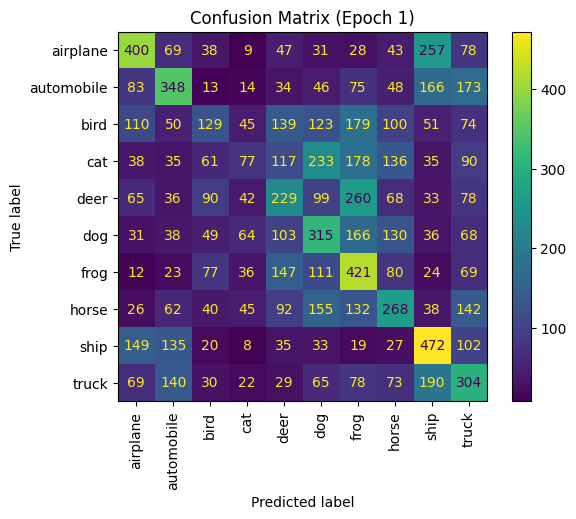

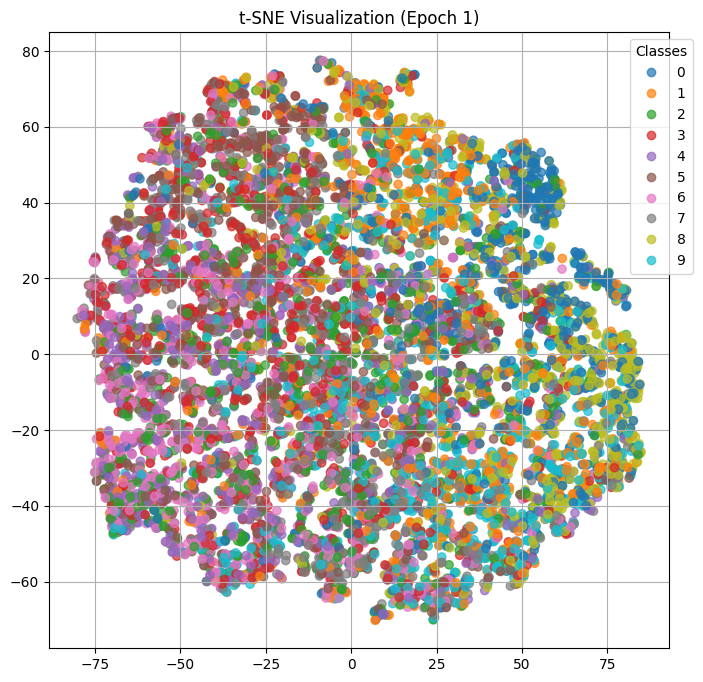

Epoch [2/5], Loss: 5.9428
Epoch [2/5], k-NN Accuracy: 0.32


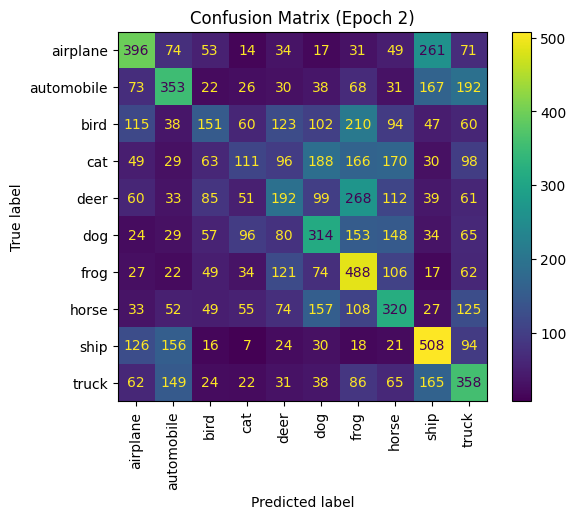

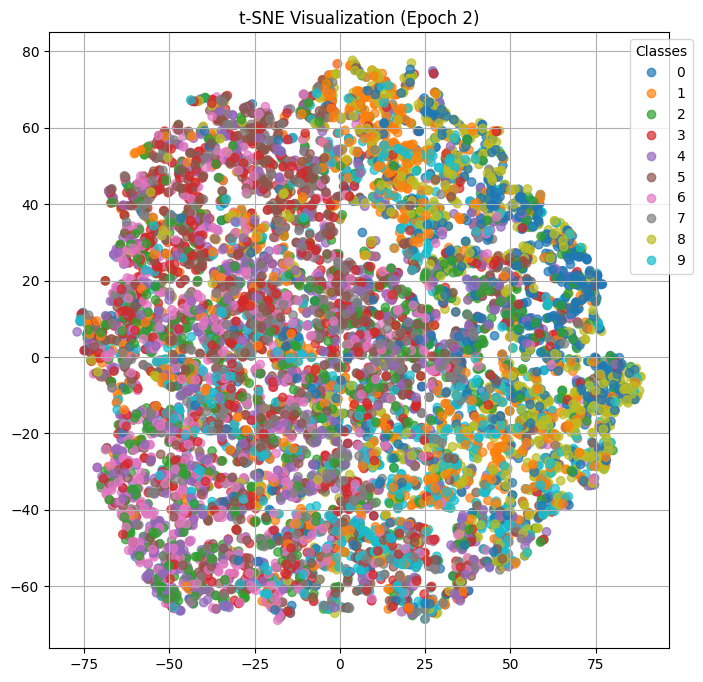

Epoch [3/5], Loss: 5.8791
Epoch [3/5], k-NN Accuracy: 0.33


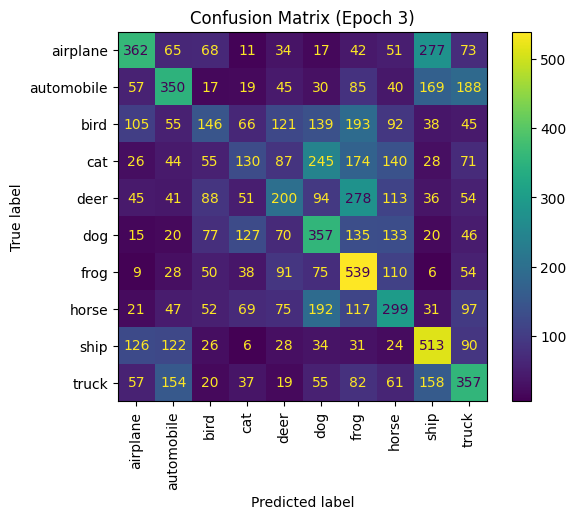

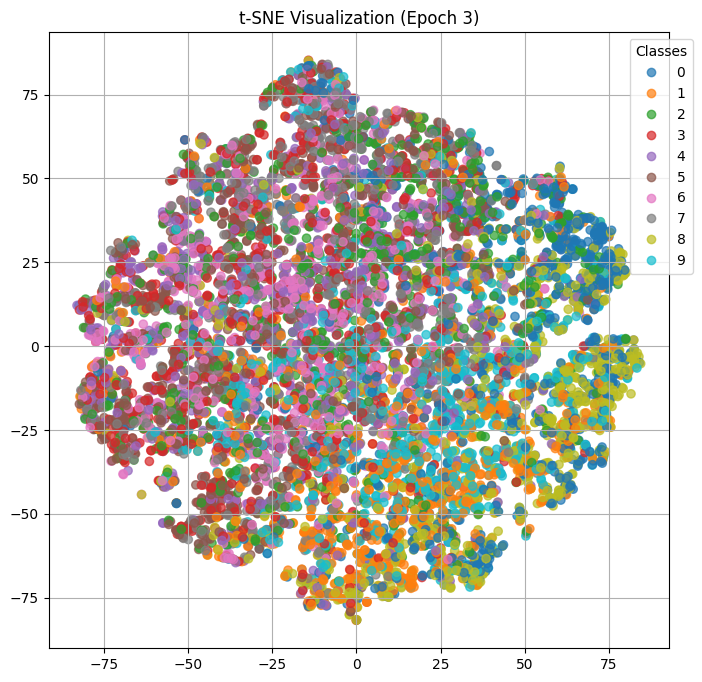

Epoch [4/5], Loss: 5.8278
Epoch [4/5], k-NN Accuracy: 0.34


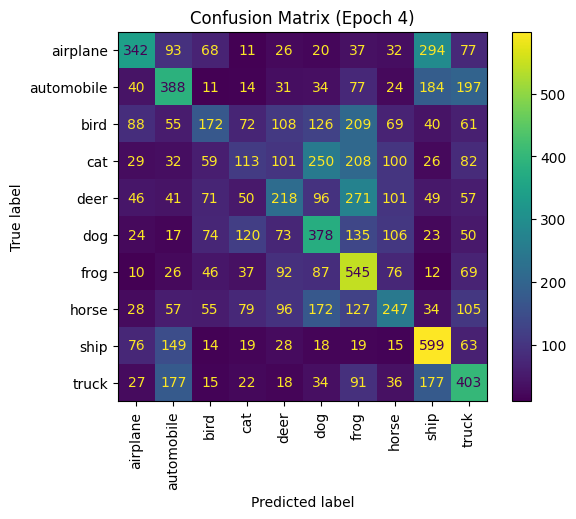

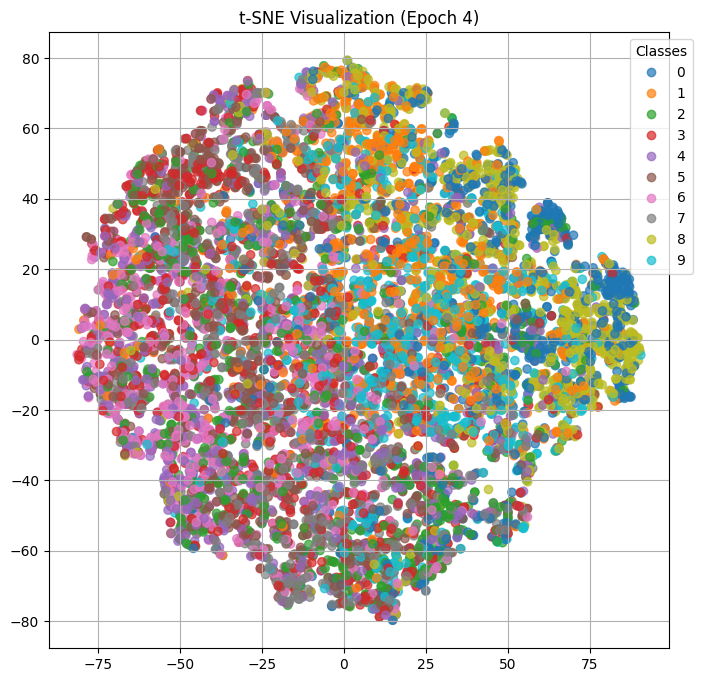

Epoch [5/5], Loss: 5.7908
Epoch [5/5], k-NN Accuracy: 0.35


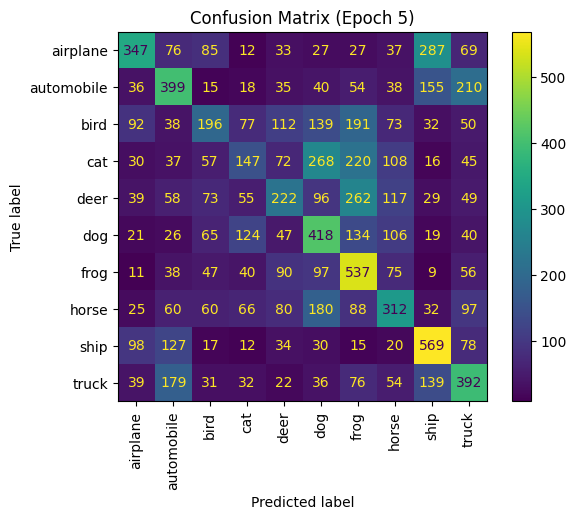

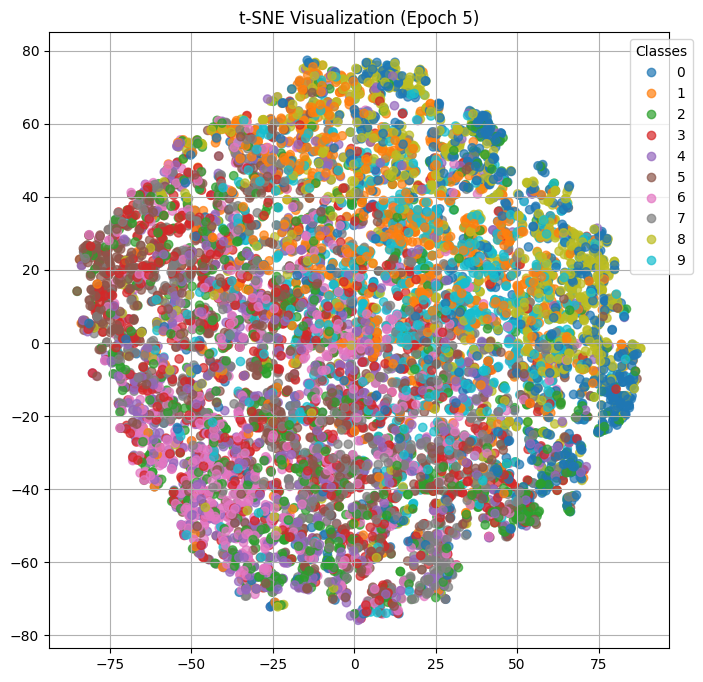

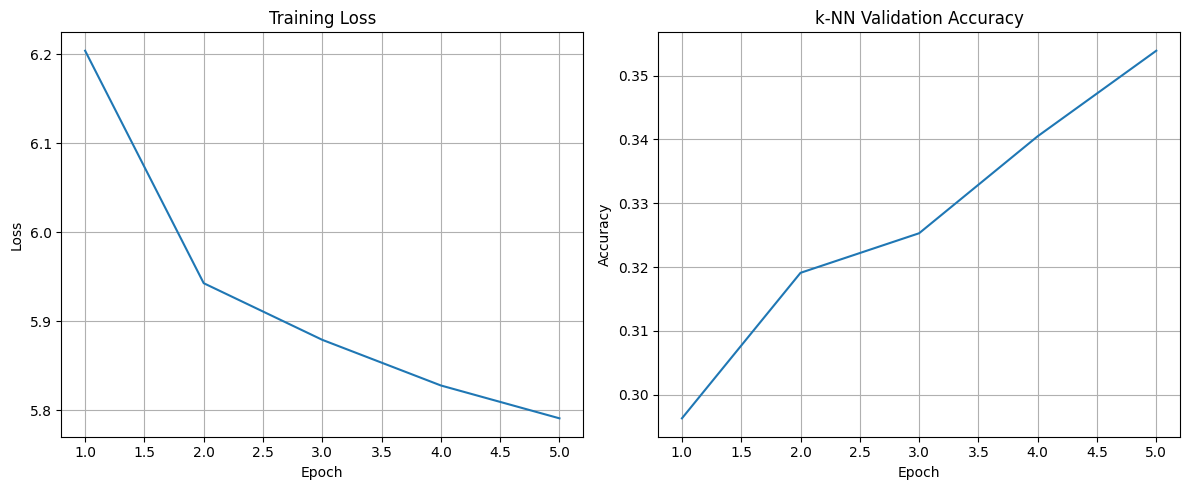

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for x1, x2, _ in train_loader:
        x1, x2 = x1.to(device), x2.to(device)
        optimizer.zero_grad()
        z1 = model(x1)
        z2 = model(x2)
        loss = nt_xent_loss(z1, z2)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    knn_acc = None
    # if (epoch + 1) % 10 == 0 or epoch == 0:
    if epoch == epoch:
        train_features, train_labels = feature_for_knn(model, train_loader, "train")
        val_features, val_labels = feature_for_knn(model, val_loader, "val")

        predictions = knn_cosine(train_features, train_labels, val_features, k=200)
        knn_acc = accuracy_score(val_labels, predictions)

        print(f'Epoch [{epoch+1}/{num_epochs}], k-NN Accuracy: {knn_acc:.2f}')

        # 混同行列
        cm = confusion_matrix(val_labels, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
        disp.plot(xticks_rotation='vertical')
        plt.title(f"Confusion Matrix (Epoch {epoch+1})")
        plt.show()

        # t-SNE可視化
        tsne = TSNE(n_components=2, random_state=0, perplexity=30)
        val_features_2d = tsne.fit_transform(val_features)

        plt.figure(figsize=(8, 8))
        scatter = plt.scatter(val_features_2d[:, 0], val_features_2d[:, 1], c=val_labels, cmap='tab10', alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1))
        plt.title(f"t-SNE Visualization (Epoch {epoch+1})")
        plt.grid(True)
        plt.show()

    history['epoch'].append(epoch+1)
    history['train_loss'].append(avg_loss)
    history['knn_accuracy'].append(knn_acc if knn_acc is not None else np.nan)

# 終了後ログ保存・学習曲線プロット
history_df = pd.DataFrame(history)
history_df.to_csv('training_log.csv', index=False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['epoch'], history['train_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['epoch'], history['knn_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('k-NN Validation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()
